# STL RNN

The goal of this notebook is to convert the char RNN example from the rnn_examples notebook into one that can process STL files.

Unfortunately, reusing code from the rnn_examples notebook did not work out as well as hoped. It did, however, serve as a quality learning exercise. The rnn_examples model is based on discrete input: language where each word is an indexed token. That leads to problems with our model as our input is continuous: each stl file has vertices that can be any real number.

After a continuous example was located, Converting proved difficult, so we borrowed some inspiration and code from https://github.com/subpath/Keras_music_gereration/blob/master/Music%20gerenation%20with%20Keras%20and%20TF.ipynb

## Setup

In [1]:
# setup
from __future__ import absolute_import, division, print_function

import tensorflow as tf
tf.enable_eager_execution()

import numpy as np
import os
import time

# autoreload changed modules!!
# https://stackoverflow.com/questions/5364050/reloading-submodules-in-ipython
%load_ext autoreload
%autoreload 2

## Data

An RNN processes data sequentially and is able to maintain an understanding of the __context__ between the current input and the last _M_ inputs.

When this concept is applied to STL files, we want the RNN to understand that triangle $T_{i}$ must share vertices with triangle $T_{i-1}$. 

Therefore, we will form our input to be 2d matrices of triangles. Each input will be a vector of shape

$$ [ x_1, y_1, z_1, x_2, y_2, z_2, x_3, y_3, z_3 ] $$

An alternate approach is to use vertices as our input. This would have a shape of

$$ [ x, y, z ] $$

Both of the above make a powerful assumption: the vertices in the STL file are in order (i.e. triangle $T_{i}$ is next to  triangle $T_{i-1}$ in the STL file). A cursory glance of several STL files confirm that the triangles are in order, but a lengthier EDA of this assumption is recommended.

In [83]:
import env
from data.thingi10k import Thingi10k
from models import MODEL_DIR

thingi = Thingi10k.init10()
n_samples = len(thingi)
n_samples

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
# jumping in to throw out TF's dataset API; it is not working as expected
# we want our data to be the shape of (batch_size, seq_length, 9) for triangles
thingi = Thingi10k.init10()

BATCH_SIZE = 9*50
SEQ_LENGTH = 90
WINDOW_SIZE = 10  # num triangles

X = list()
Y = list()
for seq in thingi.triangle_sequencer(SEQ_LENGTH):
    for i in range(len(seq) - WINDOW_SIZE):
        x = seq[i:i+WINDOW_SIZE]
        y = seq[i+WINDOW_SIZE]
        X.append(x)
        Y.append(y)
        
X = np.asarray(X)
Y = np.asarray(Y)

# the idea is that given triangle sequence X, predict the next triangle
# Y is the array that holds the next triangle
# and each triangle sequence X is the same as the previous *plus one index*
# so, X[1][-1] == Y[0]
print(X.shape)
print(Y.shape)
assert np.array_equal(X[1][-1], Y[0])

#dataset = zip(X, Y)

(61840, 10, 9)
(61840, 9)


## Build The Model

In [108]:
def build_model(window_size):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(256, input_shape=(window_size, 9), return_sequences=True),
        tf.keras.layers.Dropout(0.6),
        tf.keras.layers.LSTM(128, input_shape=(window_size, 9), return_sequences=True),
        tf.keras.layers.Dropout(0.6),
        tf.keras.layers.LSTM(64, input_shape=(window_size, 9), return_sequences=False),
        tf.keras.layers.Dropout(0.6),
        tf.keras.layers.Dense(9),
        tf.keras.layers.Activation('linear')
    ], name='stl-lstm')
    return model

In [109]:
model = build_model(window_size=WINDOW_SIZE)
optimizer = tf.train.AdamOptimizer()
model.compile(loss='mse', optimizer=optimizer)
os.makedirs(os.path.join(MODEL_DIR, 'stl_rnn', "Checkpoints"), exist_ok=True)
filepath = os.path.join(MODEL_DIR, 'stl_rnn', "Checkpoints/checkpoint_model_{epoch:02d}.hdf5")
model_save_callback = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', 
                                      verbose=1, save_best_only=False, 
                                      mode='auto', period=5)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 10, 256)           272384    
_________________________________________________________________
dropout_36 (Dropout)         (None, 10, 256)           0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 10, 128)           197120    
_________________________________________________________________
dropout_37 (Dropout)         (None, 10, 128)           0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_38 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 9)                 585       
__________

## Try The Model

In [110]:
model.fit(X, Y, batch_size=64, epochs=2, verbose=1, callbacks=[model_save_callback])

Epoch 1/2
967/967 [==============================] - 272s 282ms/step - loss: 0.0189
Epoch 2/2
967/967 [==============================] - 274s 283ms/step - loss: 0.0072


In [97]:
os.makedirs(os.path.join(MODEL_DIR, 'stl_rnn', "Checkpoints"), exist_ok=True)
tf.keras.models.save_model(
    model,
    filepath,
    overwrite=True,
    include_optimizer=True
)

## Make A Prediction

In [111]:
seed = X[0]
seed.shape

(10, 9)

In [132]:
prediction = []
x = np.expand_dims(seed, axis=0)

print_every = 1000
last_pred = None
new_preds = 0
for i in range(5000):
    preds = model.predict(x)
    x = np.squeeze(x)
    x = np.concatenate((x, preds))
    x = x[1:]
    x = np.expand_dims(x, axis=0)
    preds = np.squeeze(preds)
    if not np.array_equal(preds, last_pred):
        #print('Prediction {}: it made something new!'.format(i))
        #print('last: ', last_pred)
        #print('new: ', preds)
        new_preds += 1
    last_pred = preds
    prediction.append(preds)
    if i % print_every == 0:
        print('Prediction {}: {}'.format(i, preds))

print('new_preds: {}'.format(new_preds))

Prediction 0: [0.44583884 0.5336387  0.53269356 0.4497082  0.5348737  0.53628594
 0.44448692 0.530969   0.5382036 ]
Prediction 1000: [ 0.8566195   0.6103736  -3.060442    0.7929027   0.6941055  -3.0853424
  0.81953394  0.6597149  -3.1339579 ]
Prediction 2000: [ 0.8566195   0.61037356 -3.060442    0.7929028   0.6941056  -3.0853424
  0.81953394  0.6597149  -3.1339579 ]
Prediction 3000: [ 0.8566194   0.61037356 -3.060442    0.79290277  0.69410557 -3.0853424
  0.81953394  0.6597149  -3.1339576 ]
Prediction 4000: [ 0.8566195   0.61037356 -3.060442    0.79290265  0.6941055  -3.0853424
  0.81953394  0.6597149  -3.1339576 ]


In [134]:
vectors = thingi._reform_vectors(np.asarray(prediction))
vectors.shape

(5000, 3, 3)

In [141]:
# any coordinates out of bounds?
oob = 0
for v in vectors:
    if v.min() < 0 or v.max() > 1:
        oob += 1
        print(v)
        break
oob

[[ 0.5703409   0.54285425 -0.00143111]
 [ 0.571657    0.5439389  -0.00177643]
 [ 0.568966    0.5433558  -0.00255778]]


1

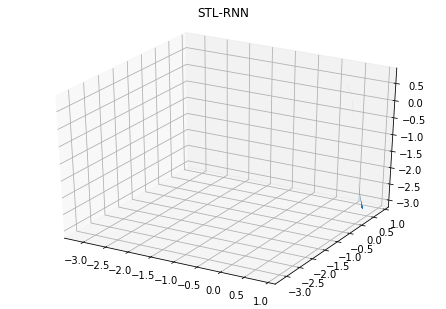

In [136]:
from data.stl import plot_mesh


plot_mesh(vectors, title='STL-RNN')


In [138]:
from data.stl import save_vectors_as_stl
save_vectors_as_stl(vectors, 'first_rnn_stl.stl')

### Failed Attempt Below

Reusing code from the rnn_examples notebook did not work out as well as hoped. It did, however, serve as a quality learning exercise. The rnn_examples model is based on discrete input: language where each word is an indexed token. That leads to problems with our model as our input is continuous: each stl file has vertices that can be any real number.

In [ ]:
for input_example_batch, target_example_batch in zip(X, Y):
    print(input_example_batch.shape)
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")
    break

In [170]:
sampled_indices = tf.random.multinomial(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [171]:
sampled_indices

array([770, 629, 737, 426, 154, 589, 950, 578, 418, 374,  55, 557, 569,
       317, 631, 749,  19, 221, 923, 696, 391,  49, 435, 913, 561, 680,
       360, 126, 191, 302, 819, 705, 650, 679, 672, 457, 130, 870, 543,
       899, 919,  16,  47, 487, 753, 167, 280, 825,  11, 823, 319, 132,
         8, 835, 515, 862, 301, 855, 411, 988, 198, 905, 488, 981, 850,
       468, 982, 182,  31,  95, 622, 306, 322, 409,  25, 368, 229,  31,
       619, 558, 242, 585, 391, 353, 197, 646, 857, 401, 472, 945, 262,
       887, 482,  45, 920, 524, 352, 870, 475])

## Optimizer & Loss

In [172]:
def loss(labels, logits):
    return tf.keras.backend.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 99, 1000)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       6.891618


## Compile Model

In [173]:
model.compile(
    optimizer=tf.train.AdamOptimizer(),
    loss=loss)

## Configure Checkpoints

In [174]:
# Directory where the checkpoints will be saved
checkpoint_dir = './_output/stl_rnn_training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

## Execute Training

In [175]:
model = build_model(
    seq_length=seq_length,
    rnn_units=rnn_units, 
    batch_size=BATCH_SIZE)

TypeError: build_model() got an unexpected keyword argument 'seq_length'

In [176]:
optimizer = tf.train.AdamOptimizer()

In [177]:
# Training step
EPOCHS = 1

for epoch in range(EPOCHS):
    start = time.time()
    
    # initializing the hidden state at the start of every epoch
    # initally hidden is None
    hidden = model.reset_states()
    
    for (batch_n, (inp, target)) in enumerate(dataset):
        with tf.GradientTape() as tape:
            # feeding the hidden state back into the model
            # This is the interesting step
            predictions = model(inp)
            loss = tf.losses.sparse_softmax_cross_entropy(target, predictions)
              
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if batch_n % 100 == 0:
            template = 'Epoch {} Batch {} Loss {:.4f}'
            print(template.format(epoch+1, batch_n, loss))

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print ('Epoch {} Loss {:.4f}'.format(epoch+1, loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

model.save_weights(checkpoint_prefix.format(epoch=epoch))

InternalError: Could not find valid device for node.
Node: {{node SparseSoftmaxCrossEntropyWithLogits}} = SparseSoftmaxCrossEntropyWithLogits[T=DT_FLOAT, Tlabels=DT_FLOAT](dummy_input, dummy_input)
All kernels registered for op SparseSoftmaxCrossEntropyWithLogits :
  device='XLA_CPU_JIT'; Tlabels in [DT_INT32, DT_INT64]; T in [DT_FLOAT, DT_DOUBLE, DT_HALF]
  device='XLA_CPU'; Tlabels in [DT_INT32, DT_INT64]; T in [DT_FLOAT, DT_DOUBLE, DT_HALF]
  device='CPU'; T in [DT_HALF]; Tlabels in [DT_INT64]
  device='CPU'; T in [DT_HALF]; Tlabels in [DT_INT32]
  device='CPU'; T in [DT_DOUBLE]; Tlabels in [DT_INT64]
  device='CPU'; T in [DT_DOUBLE]; Tlabels in [DT_INT32]
  device='CPU'; T in [DT_FLOAT]; Tlabels in [DT_INT64]
  device='CPU'; T in [DT_FLOAT]; Tlabels in [DT_INT32]
 [Op:SparseSoftmaxCrossEntropyWithLogits] name: xentropy